In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install -q scikit-learn==1.5.2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import category_encoders as ce
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

import warnings 
warnings.filterwarnings("ignore") 

%matplotlib inline

# Data downloading and preliminary review

In [4]:
# data_train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
# data_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [5]:
data_train.head(2)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241


In [6]:
# Cheking for data types
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [7]:
# Checking for NaN data

data_train.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [8]:
# Checking for values statistic info for numeric and object types
print('Statistic data for numeric values:')
display(data_train.describe(exclude='object').T)

print('\nStatistic data for Object values:')
display(data_train.describe(exclude=np.number).T)

Statistic data for numeric values:


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75000,374999.50000,562499.25000,749999.00
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97



Statistic data for Object values:


,count,unique,top,freq
Podcast_Name,750000,48,Tech Talks,22847
Episode_Title,750000,100,Episode 71,10515
Genre,750000,10,Sports,87606
Publication_Day,750000,7,Sunday,115946
Publication_Time,750000,4,Night,196849
Episode_Sentiment,750000,3,Neutral,251291


For now we'll check numeric data distribution

Text(0.5, 0.98, 'Distribution of Feature Values')

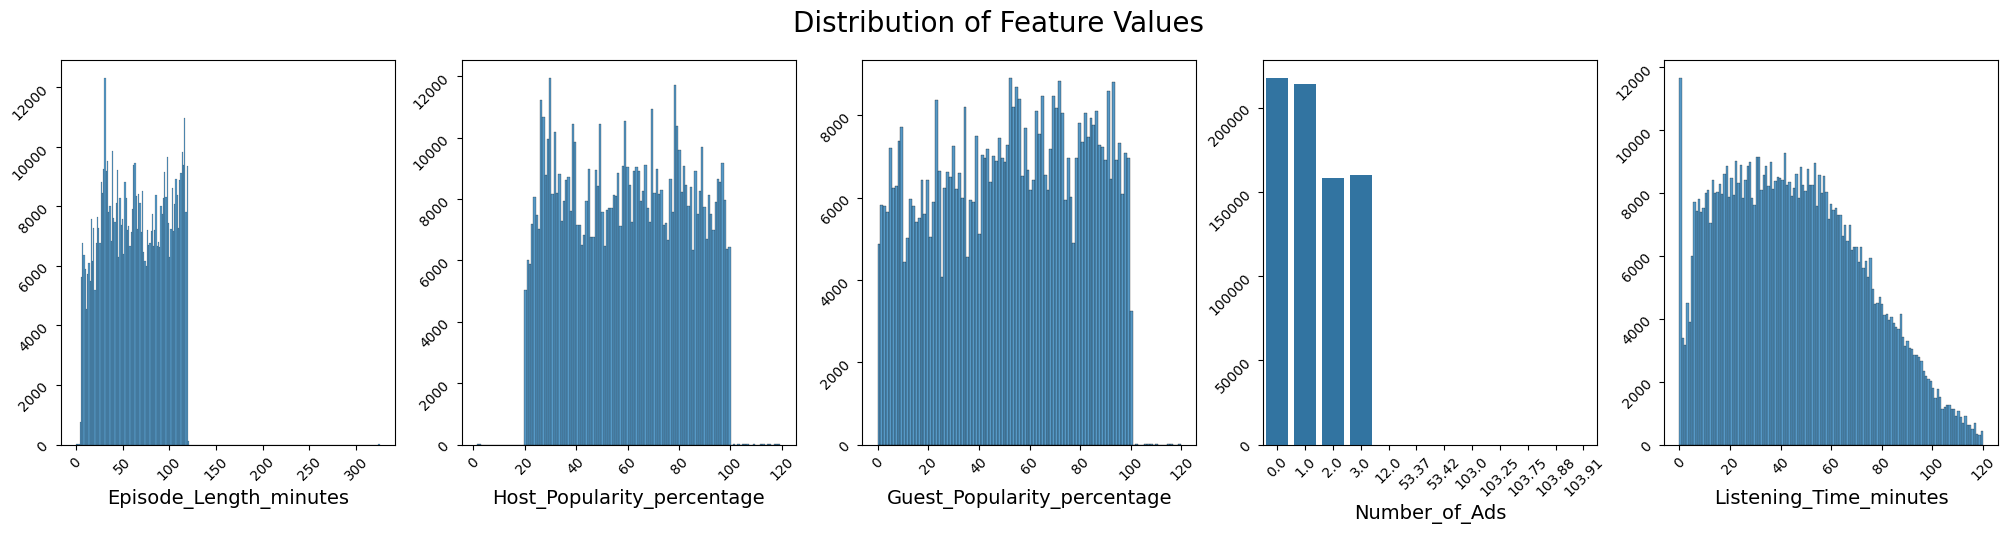

In [9]:
numeric_feats_list = list(data_train.select_dtypes([np.number]).columns)
numeric_feats_list.remove('id')

# Subplot for distribution grpaphs of numeric data
fig, axes = plt.subplots(ncols=5, nrows=1, figsize = (25, 5))

# Var for column number calculations
col = 0

# Loop for graph building 
for feat in numeric_feats_list:
    
    # Condition if-else as for one feat need counplot and for other need hisplot
    if feat != 'Number_of_Ads':
        
        # Histplot building for feats
        hist = sns.histplot(
            data_train[feat],
            ax=axes[col]
        )
        
        hist.set_ylabel('')
        hist.set_xlabel(feat, fontsize = 14)
        hist.tick_params(rotation = 45)
    
    else:
        
        # Countplot building for feat
        countpl = sns.countplot(
            data_train,
            x = feat,
            ax=axes[col]
        )
        
        countpl.set_ylabel('')
        countpl.set_xlabel(feat, fontsize = 14)
        countpl.tick_params(rotation = 45)
        
    # Var plussing for graph index switching 
    col += 1
    
fig.suptitle('Distribution of Feature Values', fontsize = 20)

# outliers in data

# Feature engineering

## Outliers in Train Data - Cleaning

Basing on distribution graphs we can make some conclusions and observants:

- **Episode_Length_minutes** - most of values are under 125 minutes, but there is some more = probably it's outliuers
- **Host_Popularity_percenatage** - most of values are under 100 %, but there're some more, it doesn't make sense as it's impossible to have more then 100
- **Guest_Popularity_percantage** - the same as before 
- **Number_of_Ads** - most values are 0, 1, 2 of 3, but there is some different values moreover some float values. Sure, it's impossible to have float value for such feat. This data shall be clean up. 
- **Listening_Time_minutes** - looks like there is no issue in data. We have some peak value for about 0 minutes. It's also could be, probably some users started listening by mistake or started podcast for listening latter. 

Anyway let's make boxplots to be sure. 

Text(0.5, 0.98, 'Boxplots for numeric features')

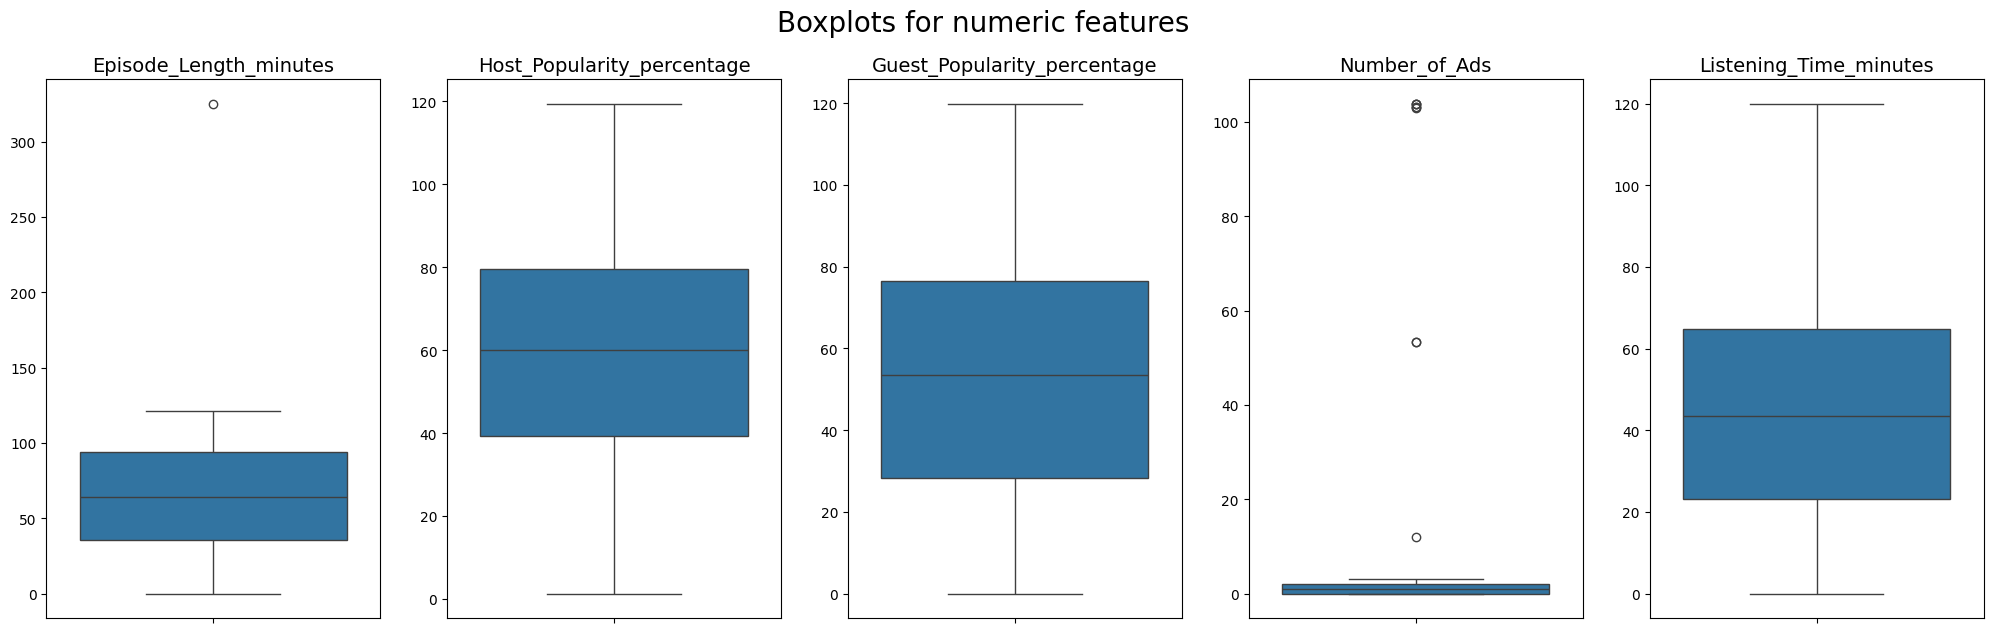

In [10]:
# Subplot for distribution grpaphs of numeric data
fig, axes = plt.subplots(ncols=5, nrows=1, figsize = (25, 7))

# Var for column number calculations
col = 0

# Loop for graph building 
for feat in numeric_feats_list:
    box = sns.boxplot(
        data_train, 
        y = feat, 
        orient='v',
        ax=axes[col]
    )
    
    box.set_title(feat, fontsize = 14)
    box.set_ylabel('')
    
    col += 1
    
fig.suptitle('Boxplots for numeric features', fontsize = 20)

For features Episode_Length_minutes and Number_of_Ads there is no need to calculate left bound of boxplot, we'll take it visually: 

For **Episode_Length_minutes** it's **125**

For **Number_of_Ads** it's **3**

Let's check how many examples of outliers we have.

In [11]:
episode_lenght_out = data_train[data_train['Episode_Length_minutes'] > 125].value_counts().sum()
number_of_ads_out = data_train[data_train['Number_of_Ads'] > 3].value_counts().sum()

print('Numbers of outliers in episode_lenght_out feature is:', episode_lenght_out)
print('Numbers of outliers in Number_of_Ads feature is:', number_of_ads_out)


Numbers of outliers in episode_lenght_out feature is: 1
Numbers of outliers in Number_of_Ads feature is: 7


Also, it's strange to have more then 100 % of popularity. Need to check it as well. 

In [12]:
host_popularity_out = data_train[data_train['Host_Popularity_percentage'] > 100].value_counts().sum()
guest_popularity_out = data_train[data_train['Guest_Popularity_percentage'] > 100].value_counts().sum()

print('Numbers of probably oulliers in Host_Popularity_percentage feature is:', host_popularity_out)
print('Numbers of probably oulliers in Guest_Popularity_percentage feature is:', guest_popularity_out)

Numbers of probably oulliers in Host_Popularity_percentage feature is: 24
Numbers of probably oulliers in Guest_Popularity_percentage feature is: 14


Not to much of examples. Let's drop them. 

In [13]:
# Indexes lists to drop
episode_lenght_out_index = list(data_train[data_train['Episode_Length_minutes'] > 125].index)
number_of_ads_out_index = list(data_train[data_train['Number_of_Ads'] > 3].index)
host_popularity_out_index = list(data_train[data_train['Host_Popularity_percentage'] > 100].index)
guest_popularity_out_index = list(data_train[data_train['Guest_Popularity_percentage'] > 100].index)

index_to_drop = set(episode_lenght_out_index + 
                    number_of_ads_out_index + 
                    host_popularity_out_index + 
                    guest_popularity_out_index
                    )

index_to_drop = list(index_to_drop)

For now we'll make copy of DF and clean it

In [14]:
df_cleaned = data_train.copy()

df_cleaned = df_cleaned.drop(index=index_to_drop, axis=0)
df_cleaned = df_cleaned.drop('id', axis=1)
df_cleaned = df_cleaned.reset_index(drop=True)


df_cleaned.shape

(749946, 11)

And as a final let's check for duplicates

In [15]:
print(f'Data Frame contains {df_cleaned.duplicated().sum()} duplicates')

Data Frame contains 0 duplicates


## Outliers in Test Data - Cleaning

It's impossible to delete or clean test data, so we need to observe it and make desicion what to do.

In [16]:
display(data_test.describe(exclude='object').T)
display(data_test.describe(exclude=np.number).T)

,count,mean,std,min,25%,50%,75%,max
id,250000.0,874999.500000,72168.927986,750000.00,812499.75,874999.50,937499.25,999999.00
Episode_Length_minutes,221264.0,419.298741,166854.502468,2.47,35.78,63.97,94.15,78486264.00
Host_Popularity_percentage,250000.0,59.716491,22.880028,2.49,39.25,59.90,79.39,117.76
Guest_Popularity_percentage,201168.0,52.192796,28.445034,0.00,28.32,53.36,76.56,116.82
Number_of_Ads,250000.0,1.355852,4.274399,0.00,0.00,1.00,2.00,2063.00


,count,unique,top,freq
Podcast_Name,250000,48,Tech Talks,7553
Episode_Title,250000,100,Episode 71,3492
Genre,250000,10,Sports,28903
Publication_Day,250000,7,Sunday,38906
Publication_Time,250000,4,Night,65440
Episode_Sentiment,250000,3,Neutral,83671


We see strange values in **Episode_Length_minutes** - maximum value is 78486264.00 minutes;

In **Host_Popularity_percentage** and **Guest_Popularity_percentage** there're values more then 100 %;

In **Number_of_Ads** maximum value is 2063.00.


We'll do like this:

For **Episode_Length_minutes** abnormal data we'll refill with medium feature value;

For **Host_Popularity_percentage** and **Guest_Popularity_percentage** we'll refill values which are more then 100 with 100%;

For **Number_of_Ads** we'll refill with feature mode value.


In [17]:
data_test['Episode_Length_minutes'] = \
    data_test['Episode_Length_minutes'].apply(
        lambda x: data_test['Episode_Length_minutes'].median() if x > 125 else x
        )
    
data_test['Number_of_Ads'] = \
    data_test['Number_of_Ads'].apply(
        lambda x: data_test['Number_of_Ads'].mode() if x > 3 else x
    )
    
data_test['Host_Popularity_percentage'] = \
    data_test['Host_Popularity_percentage'].apply(
        lambda x: 100 if x > 100 else x
    ) 
    
data_test['Guest_Popularity_percentage'] = \
    data_test['Guest_Popularity_percentage'].apply(
        lambda x: 100 if x > 100 else x
    ) 

And also drop 'id' feature.

In [18]:
data_test = data_test.drop('id', axis=1)

Let's check if shape of both DataFrames are equal.

In [19]:
print(df_cleaned.shape[1])
print(data_test.shape[1])

11
10


Quantity of features are **equal** (in the df_cleaned is 11 **as there is still target feature inside**)

## Data splitting

Before further actions let's split our DF to target and predictors data.

It's neccessary to do here as following we will encode our features. And the same actions need to do with test data, so the shapes must be same.

In [20]:
# Target data
y = df_cleaned['Listening_Time_minutes']

# predictors data
df_cleaned = df_cleaned.drop('Listening_Time_minutes', axis=1)

## Feature encoding

Here we'll create lists of object features and encode it.
For the quantity of feature unique values less then 15 we'll use One Hot Encoding, if more - Binary Encoding.

In [21]:
object_columns = list(df_cleaned.select_dtypes('object').columns)

one_hot_list = list()
binary_list = list()

for feat in object_columns:
    unique_values = df_cleaned[feat].nunique()
    print(f'Unique values for {feat} is {unique_values}')
    
    if unique_values > 15:
        binary_list.append(feat)
    
    else:
        one_hot_list.append(feat)
    

Unique values for Podcast_Name is 48
Unique values for Episode_Title is 100
Unique values for Genre is 10
Unique values for Publication_Day is 7
Unique values for Publication_Time is 4
Unique values for Episode_Sentiment is 3


In [22]:
one_hot_encoder = OneHotEncoder()

data_onehot = one_hot_encoder.fit_transform(df_cleaned[one_hot_list]).toarray()

one_hot_col_names = one_hot_encoder.get_feature_names_out(one_hot_list)
df_onehot = pd.DataFrame(data_onehot, columns=one_hot_col_names)
df_onehotted = pd.concat([df_cleaned, df_onehot], axis=1)
df_onehotted = df_onehotted.drop(one_hot_list, axis=1)

In [23]:
bin_encoder = ce.BinaryEncoder(cols=binary_list)

feat_binned = bin_encoder.fit_transform(df_onehotted[binary_list])

In [24]:
df_encoded = pd.concat([df_onehotted, feat_binned], axis=1)

df_encoded = df_encoded.drop(binary_list, axis=1)

Let's do the same for test Dataset, **based on created enoders.**

In [25]:
data_onehot_test = one_hot_encoder.transform(data_test[one_hot_list]).toarray()

one_hot_col_names = one_hot_encoder.get_feature_names_out(one_hot_list)
df_onehot_test = pd.DataFrame(data_onehot_test, columns=one_hot_col_names)
df_onehotted_test = pd.concat([data_test, df_onehot_test], axis=1)
df_onehotted_test = df_onehotted_test.drop(one_hot_list, axis=1)

In [26]:
feat_binned_test = bin_encoder.transform(df_onehotted_test[binary_list])

df_encoded_test = pd.concat([df_onehotted_test, feat_binned_test], axis=1)

df_encoded_test = df_encoded_test.drop(binary_list, axis=1)

## Missing Data Imputation

### Missing Data Imputation - Train Data

Let's check the Data which is missed in our dataset.

In [27]:
df_encoded.isna().sum()

for n in range(df_encoded.shape[1]):
    
    if df_encoded.isna().sum()[n] != 0:
        print('\nFeature {} has {} missings'.format(
            df_encoded.isna().sum().index[n], 
            df_encoded.isna().sum()[n]
        ))


Feature Episode_Length_minutes has 87087 missings

Feature Guest_Popularity_percentage has 146028 missings

Feature Number_of_Ads has 1 missings


And for test data

In [28]:
df_encoded_test.isna().sum()

for n in range(df_encoded_test.shape[1]):
    
    if df_encoded_test.isna().sum()[n] != 0:
        print('\nFeature {} has {} missings'.format(
            df_encoded_test.isna().sum().index[n], 
            df_encoded_test.isna().sum()[n]
        ))


Feature Episode_Length_minutes has 28736 missings

Feature Guest_Popularity_percentage has 48832 missings


**How will we do**

For the train data one missed value in **Number_of_Ads** we will fill with mode value.

For **other** missed data in features we will use filling with ML prediction values. 

So, we will create and train Linear regression model on train data and further apply it to test data.

In [29]:
df_encoded['Number_of_Ads'] = df_encoded['Number_of_Ads'].fillna(
    df_encoded['Number_of_Ads'].mode()[0]
)

In [30]:
df_encoded.isna().sum()

Episode_Length_minutes          87087
Host_Popularity_percentage          0
Guest_Popularity_percentage    146028
Number_of_Ads                       0
Genre_Business                      0
Genre_Comedy                        0
Genre_Education                     0
Genre_Health                        0
Genre_Lifestyle                     0
Genre_Music                         0
Genre_News                          0
Genre_Sports                        0
Genre_Technology                    0
Genre_True Crime                    0
Publication_Day_Friday              0
Publication_Day_Monday              0
Publication_Day_Saturday            0
Publication_Day_Sunday              0
Publication_Day_Thursday            0
Publication_Day_Tuesday             0
Publication_Day_Wednesday           0
Publication_Time_Afternoon          0
Publication_Time_Evening            0
Publication_Time_Morning            0
Publication_Time_Night              0
Episode_Sentiment_Negative          0
Episode_Sent

In [31]:
# ##### ORIGINAL
# break
# # Make a copy - it will be missing-free and will be 
# # used as train data for value predictions
# data = df_encoded.copy()

# # This DF has all missed data and from this will be generated missed values
# test_data = data[data['Episode_Length_minutes'].isnull()]

# # Clean it from missed data
# data.dropna(inplace=True)

# # Target data for training
# y_train = data['Episode_Length_minutes']

# # Predictrors for train and test data
# X_train = data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)
# X_test = test_data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)

# # Model initialisation
# model_episode_length = LinearRegression()

# # Model training
# model_episode_length.fit(X_train, y_train)

# # prediction based on test data
# y_pred = model_episode_length.predict(X_test)

# # Filling our DF with predicted data based on indexes and values
# for i, ni in enumerate(test_data.index):
#     df_encoded.loc[ni, 'Episode_Length_minutes'] = y_pred[i]


In [32]:
##### TRY HYPEROPT

import time

# Make a copy - it will be missing-free and will be 
# used as train data for value predictions
data = df_encoded.copy()

# This DF has all missed data and from this will be generated missed values
test_data = data[data['Episode_Length_minutes'].isnull()]

# Clean it from missed data
data.dropna(inplace=True)

# Target data for training
y_train = data['Episode_Length_minutes']

# Predictrors for train and test data
X_train = data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)
X_test = test_data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)

r_scaller_filling_ep_leng = preprocessing.RobustScaler()
# break
X_train_scaled = r_scaller_filling_ep_leng.fit_transform(X_train)
X_test_scaled = r_scaller_filling_ep_leng.transform(X_test)

#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import ElasticNet
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

space = {
    'alpha': hp.loguniform('alpha', -3, 3),  # 0.05 до 20
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'max_iter': hp.quniform('max_iter', 500, 2000, 100),
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}
    #    'min_samples_leaf': hp.choice('min_samples_leaf', 2, 10, 1)
    

random_state = 42
def hyperopt_rf(space, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    # params = {'n_estimators': int(params['n_estimators']), 
    #           'max_depth': int(params['max_depth']), 
    #          'min_samples_leaf': int(params['min_samples_leaf'])
    #           }
    
    params = {'alpha': float(space['alpha']),
        'l1_ratio': float(space['l1_ratio']),
        'max_iter': int(space['max_iter']),
        'fit_intercept': space['fit_intercept']}

  
  
    # используем эту комбинацию для построения модели
    model = ElasticNet(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_mean_squared_error'  # для регрессии
    ).mean()
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


# рассчитаем точность для тестовой выборки
model_ep_leng = ElasticNet(
    random_state=random_state, 
    alpha = float(best['alpha']),
    l1_ratio = float(best['l1_ratio']),
    max_iter = int(best['max_iter']),
    fit_intercept = bool(best['fit_intercept'])
    )


# model = ensemble.RandomForestClassifier(
#     random_state=random_state, 
#     n_estimators=int(best['n_estimators']),
#     max_depth=int(best['max_depth']),
#     min_samples_leaf=int(best['min_samples_leaf'])
# )
model_ep_leng.fit(X_train_scaled, y_train)
y_train_pred = model_ep_leng.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.mean_squared_error(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model_ep_leng.predict(X_test_scaled)

for i, ni in enumerate(test_data.index):
    df_encoded.loc[ni, 'Episode_Length_minutes'] = y_test_pred[i]

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [03:30<00:00, 10.52s/trial, best loss: 1076.344377238302]
Наилучшие значения гиперпараметров {'alpha': 0.12784690358929376, 'fit_intercept': 0, 'l1_ratio': 0.07366102545052411, 'max_iter': 700.0}
f1_score на обучающем наборе: 1170.96


In [33]:
y_test_pred

array([45.31872253, 55.84591456, 57.13305192, ..., 71.30032335,
       71.95896451, 58.62397883])

In [34]:
df_encoded.isna().sum()

Episode_Length_minutes              0
Host_Popularity_percentage          0
Guest_Popularity_percentage    146028
Number_of_Ads                       0
Genre_Business                      0
Genre_Comedy                        0
Genre_Education                     0
Genre_Health                        0
Genre_Lifestyle                     0
Genre_Music                         0
Genre_News                          0
Genre_Sports                        0
Genre_Technology                    0
Genre_True Crime                    0
Publication_Day_Friday              0
Publication_Day_Monday              0
Publication_Day_Saturday            0
Publication_Day_Sunday              0
Publication_Day_Thursday            0
Publication_Day_Tuesday             0
Publication_Day_Wednesday           0
Publication_Time_Afternoon          0
Publication_Time_Evening            0
Publication_Time_Morning            0
Publication_Time_Night              0
Episode_Sentiment_Negative          0
Episode_Sent

In [35]:
# For the comments here please look upper - all the same 
# Only exception is here dropping only one feature as other has been filled before

data = df_encoded.copy()

test_data = data[data['Guest_Popularity_percentage'].isnull()]

data.dropna(inplace=True)

y_train = data['Guest_Popularity_percentage']

X_train = data.drop(['Guest_Popularity_percentage'], axis=1)
X_test = test_data.drop(['Guest_Popularity_percentage'], axis=1)

r_scaller_filling_guest_pop = preprocessing.RobustScaler()
# break
X_train_scaled = r_scaller_filling_guest_pop.fit_transform(X_train)
X_test_scaled = r_scaller_filling_guest_pop.transform(X_test)


space = {
    'alpha': hp.loguniform('alpha', -3, 3),  # 0.05 до 20
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'max_iter': hp.quniform('max_iter', 500, 2000, 100),
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}
    #    'min_samples_leaf': hp.choice('min_samples_leaf', 2, 10, 1)
    

random_state = 42

def hyperopt_rf(space, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    # params = {'n_estimators': int(params['n_estimators']), 
    #           'max_depth': int(params['max_depth']), 
    #          'min_samples_leaf': int(params['min_samples_leaf'])
    #           }
    
    params = {'alpha': float(space['alpha']),
        'l1_ratio': float(space['l1_ratio']),
        'max_iter': int(space['max_iter']),
        'fit_intercept': space['fit_intercept']}

  
  
    # используем эту комбинацию для построения модели
    model = ElasticNet(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_mean_squared_error'  # для регрессии
    ).mean()
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


# рассчитаем точность для тестовой выборки
model_guest_pop = ElasticNet(
    random_state=random_state, 
    alpha = float(best['alpha']),
    l1_ratio = float(best['l1_ratio']),
    max_iter = int(best['max_iter']),
    fit_intercept = bool(best['fit_intercept'])
    )


# model = ensemble.RandomForestClassifier(
#     random_state=random_state, 
#     n_estimators=int(best['n_estimators']),
#     max_depth=int(best['max_depth']),
#     min_samples_leaf=int(best['min_samples_leaf'])
# )
model_guest_pop.fit(X_train_scaled, y_train)
y_train_pred = model_guest_pop.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.mean_squared_error(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model_guest_pop.predict(X_test_scaled)



# from sklearn.linear_model import LinearRegression

# model_guest_pop = LinearRegression()

# model_guest_pop.fit(X_train, y_train)

# y_pred = model_guest_pop.predict(X_test)

for i, ni in enumerate(test_data.index):
    df_encoded.loc[ni, 'Guest_Popularity_percentage'] = y_test_pred[i]


CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [03:44<00:00, 11.24s/trial, best loss: 808.4281053375873]
Наилучшие значения гиперпараметров {'alpha': 0.12784690358929376, 'fit_intercept': 0, 'l1_ratio': 0.07366102545052411, 'max_iter': 700.0}
f1_score на обучающем наборе: 867.66


### Missing Data Imputation - Train Data

Let's do all the same for **Test Data.** Ofcourse here are using models which has been trained on train data.

In [36]:
# For the code comments please check upper

data = df_encoded_test.copy()

test_data = data[data['Episode_Length_minutes'].isnull()]

data.dropna(inplace=True)

y_train = data['Episode_Length_minutes']

X_train = data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)
X_test = test_data.drop(['Episode_Length_minutes', 'Guest_Popularity_percentage'], axis=1)

X_train_scaled = r_scaller_filling_ep_leng.transform(X_train)
X_test_scaled = r_scaller_filling_ep_leng.transform(X_test)

# Here we using the model trained on the Train Data
y_pred = model_ep_leng.predict(X_test_scaled)

for i, ni in enumerate(test_data.index):
    df_encoded_test.loc[ni, 'Episode_Length_minutes'] = y_pred[i]

In [37]:
data = df_encoded_test.copy()

test_data = data[data['Guest_Popularity_percentage'].isnull()]

data.dropna(inplace=True)

y_train = data['Guest_Popularity_percentage']

X_train = data.drop(['Guest_Popularity_percentage'], axis=1)
X_test = test_data.drop(['Guest_Popularity_percentage'], axis=1)

X_train_scaled = r_scaller_filling_guest_pop.transform(X_train)
X_test_scaled = r_scaller_filling_guest_pop.transform(X_test)

# Here we using the model trained on the Train Data
y_pred = model_guest_pop.predict(X_test_scaled)

for i, ni in enumerate(test_data.index):
    df_encoded_test.loc[ni, 'Guest_Popularity_percentage'] = y_pred[i]

In [38]:
df_encoded_test.isna().sum()

Episode_Length_minutes         0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Genre_Business                 0
Genre_Comedy                   0
Genre_Education                0
Genre_Health                   0
Genre_Lifestyle                0
Genre_Music                    0
Genre_News                     0
Genre_Sports                   0
Genre_Technology               0
Genre_True Crime               0
Publication_Day_Friday         0
Publication_Day_Monday         0
Publication_Day_Saturday       0
Publication_Day_Sunday         0
Publication_Day_Thursday       0
Publication_Day_Tuesday        0
Publication_Day_Wednesday      0
Publication_Time_Afternoon     0
Publication_Time_Evening       0
Publication_Time_Morning       0
Publication_Time_Night         0
Episode_Sentiment_Negative     0
Episode_Sentiment_Neutral      0
Episode_Sentiment_Positive     0
Podcast_Name_0                 0
Podcast_Name_1                 0
Podcast_Na

## Polinomial features

In [39]:
# Copy of cleaned data to following actions
X = df_encoded.copy()

In [40]:
# Splitting of Train data to train and test datasets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)


Here we starting create polynomial features. To avoid huge loading for calculations, **we will reduce the numbers width to 16 bits.**

In [41]:
# creating lists with features name according to dtype
float_feats = list(X_train.select_dtypes('float64').columns)
int_feats = list(X_train.select_dtypes('int64').columns)

In [42]:
# Reducing numbers width 
for feat in float_feats:
    X_train[feat] = X_train[feat].astype('float16')
    X_test[feat] = X_test[feat].astype('float16')
    
for feat in int_feats:
    X_train[feat] = X_train[feat].astype('int16')
    X_test[feat] = X_test[feat].astype('int16')

In [43]:
# Creating polynomializer
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Study it
poly.fit(X_train)

# Creating of new feats
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

Creating polinimial features for test data

In [44]:
# Reducing numbers width 
for feat in float_feats:
    df_encoded_test[feat] = df_encoded_test[feat].astype('float16')
    
for feat in int_feats:
    df_encoded_test[feat] = df_encoded_test[feat].astype('int16')

In [45]:
df_encoded_test_poly = poly.transform(df_encoded_test)

# Base-Line model XGBRegressor

And now we are ready to create model and train it.

## Model creating and training od train data

In [41]:
model_xgb = XGBRegressor(n_estimators=10000,
                            learning_rate=0.02,
                            enable_categorical=True,
                            device='cuda', 
                            random_state=42,
                        )
model_xgb.fit(
    X_train_poly, y_train,
    verbose=200,
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
y_pred_train_xgb = model_xgb.predict(X_test_poly)

print('Root mean squared error for train data = {}'.format(
    root_mean_squared_error(y_test, y_pred_train_xgb)
    ))

Root mean squared error for train data = 13.010386607633468


In [56]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import numpy as np
from sklearn import metrics

# Пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 3000, 100),  # разумное количество деревьев
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),  # скорость обучения
    'max_depth': hp.quniform('max_depth', 3, 12, 1),  # глубина деревьев
    'subsample': hp.uniform('subsample', 0.6, 1.0),  # часть объектов для обучения каждого дерева
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),  # часть признаков для каждого дерева
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),  # L2-регуляризация
    'reg_alpha': hp.uniform('reg_alpha', 0, 10)  # L1-регуляризация
}

# Функция оценки модели
def hyperopt_xgb(space, cv=5, X=X_train_poly, y=y_train, random_state=random_state):
    params = {
        'n_estimators': int(space['n_estimators']), 
        'learning_rate': float(space['learning_rate']), 
        'max_depth': int(space['max_depth']), 
        'subsample': float(space['subsample']),
        'colsample_bytree': float(space['colsample_bytree']),
        'reg_lambda': float(space['reg_lambda']),
        'reg_alpha': float(space['reg_alpha']),
    }

    # Инициализация модели с заданными параметрами
    model = XGBRegressor(**params)

    # Оцениваем модель с использованием кросс-валидации
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    
    # Возвращаем отрицательное значение среднего RMSE для оптимизации
    return -scores.mean()



# Запуск оптимизации
trials = Trials()

best = fmin(
    fn=hyperopt_xgb,
    space=space,
    algo=tpe.suggest,
    max_evals=30,  # можно начать с 30-50
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Наилучшие параметры:")
print(best)

# Обучение финальной модели с лучшими параметрами
model_xgb = XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=float(best['learning_rate']),
    max_depth=int(best['max_depth']),
    subsample=float(best['subsample']),
    colsample_bytree=float(best['colsample_bytree']),
    reg_lambda=float(best['reg_lambda']),
    reg_alpha=float(best['reg_alpha']),
    booster='gbtree',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train_poly, y_train)
y_test_pred = model_xgb.predict(X_test_poly)

print('RMSE на тесте: {:.4f}'.format(metrics.root_mean_squared_error(y_test, y_test_pred)))


  3%|▎         | 1/30 [2:07:01<61:23:41, 7621.43s/trial, best loss: 13.075194355134451]


KeyboardInterrupt: 

In [ ]:
# DEFAULT SHOTGUN

space={'n_estimators': hp.quniform('n_estimators', 1000, 20000, 100),
       'learning_rate': hp.loguniform('lr_linear', np.log(0.001), np.log(0.1)),
       'reg_lambda': hp.uniform('lambda_linear', 0, 10),
       'reg_alpha': hp.uniform('alpha_linear', 0, 10),
       'feature_selector': hp.choice('feature_selector', ['cyclic', 'shuffle', 'random'])

      }

def hyperopt_xgb(space, cv=5, X=X_train_poly, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(space['n_estimators']), 
              'learning_rate': float(space['learning_rate']), 
             'reg_lambda': float(space['reg_lambda']),
            'reg_alpha': float(space['reg_alpha']),
            'feature_selector': (space['feature_selector'])
              }
  
    # используем эту комбинацию для построения модели
    model = XGBRegressor(**params, random_state=random_state, booster = 'gblinear', updater='shotgun')

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_root_mean_squared_error'  # для регрессии
    ).mean()
    
    
    return -score
#############################################################
%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_xgb, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

feature_selector_options = ['cyclic', 'shuffle', 'random']
selected_selector = feature_selector_options[best['feature_selector']]

model_xgb = XGBRegressor(n_estimators=int(best['n_estimators']),
                            learning_rate=float(best['learning_rate']),
                            reg_lambda = float(best['reg_lambda']),
                            reg_alpha = float(best['reg_alpha']),
                            # feature_selector = best['feature_selector'],
                            feature_selector=selected_selector,
                            enable_categorical=True,
                            device='cpu', 
                            random_state=42,
                            booster = 'gblinear'
                        )


model_xgb.fit(X_train_poly, y_train)
y_test_pred = model_xgb.predict(X_test_poly)
print('RMSE_score на обучающем наборе: {:.2f}'.format(metrics.root_mean_squared_error(y_test, y_test_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
# y_test_pred = model_xgb.predict(X_test_poly)




CPU times: total: 0 ns
Wall time: 0 ns
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

In [ ]:
# WITH GREEDY

space={'n_estimators': hp.quniform('n_estimators', 1000, 20000, 100),
       'learning_rate' : hp.quniform('learning_rate', 0, 1, 0.01),
       'reg_lambda': hp.quniform('reg_lambda', 0, 100, 1),
       'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
       'feature_selector': hp.choice('feature_selector', ['random', 'greedy', 'thrifty'])

      }

def hyperopt_xgb(space, cv=5, X=X_train_poly, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(space['n_estimators']), 
              'learning_rate': float(space['learning_rate']), 
             'reg_lambda': float(space['reg_lambda']),
            'reg_alpha': float(space['reg_alpha']),
            'feature_selector': (space['feature_selector'])
              }
  
    # используем эту комбинацию для построения модели
    model = XGBRegressor(**params, random_state=random_state, booster = 'gblinear', updater = 'coord_descent')

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_mean_squared_error'  # для регрессии
    ).mean()
    
    
    return -score
#############################################################
%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_disc=fmin(hyperopt_xgb, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

feature_selector_options = ['random', 'greedy', 'thrifty']
selected_selector = feature_selector_options[best['feature_selector']]

model_xgb_disc = XGBRegressor(n_estimators=int(best_disc['n_estimators']),
                            learning_rate=float(best_disc['learning_rate']),
                            reg_lambda = float(best_disc['reg_lambda']),
                            reg_alpha = float(best_disc['reg_alpha']),
                            feature_selector=selected_selector,
                            
                            enable_categorical=True,
                            device='cpu', 
                            random_state=42,
                            booster = 'gblinear',
                            updater = 'coord_descent'
                        )


model_xgb_disc.fit(X_train_poly, y_train)
y_test_pred_disc = model_xgb_disc.predict(X_test_poly)
print('RMSE_score на обучающем наборе: {:.2f}'.format(metrics.root_mean_squared_error(y_test, y_test_pred_disc)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
# y_test_pred_disc = model_xgb_disc.predict(X_test_poly)




In [51]:
from hyperopt import space_eval

space = hp.choice('model_type', [
    {  # Вариант для gbtree
        'booster': 'gbtree',
        'n_estimators': hp.quniform('n_estimators_tree', 100, 1000, 50),
        'learning_rate': hp.uniform('lr_tree', 0.01, 0.3),
        'reg_lambda': hp.uniform('lambda_tree', 0, 10),
        'reg_alpha': hp.uniform('alpha_tree', 0, 10)
    },
    {  # Вариант для gblinear
        'booster': 'gblinear',
        'n_estimators': hp.quniform('n_estimators_linear', 10, 200, 10),
        'learning_rate': hp.uniform('lr_linear', 0.001, 0.1),
        'reg_lambda': hp.uniform('lambda_linear', 0, 10),
        'reg_alpha': hp.uniform('alpha_linear', 0, 10),
        'feature_selector': hp.choice('feature_selector', ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty'])
    }
])

def hyperopt_xgb(params, cv=5, X=X_train_poly, y=y_train, random_state=random_state):
    params = {
        'booster': params['booster'],
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'reg_lambda': params['reg_lambda'],
        'reg_alpha': params['reg_alpha'],
        'random_state': random_state
    }
    
    if params['booster'] == 'gblinear':
        params['feature_selector'] = params.get('feature_selector', 'cyclic')
        params['updater'] = 'shotgun'  # Обязательный параметр для gblinear

    model = XGBRegressor(**params)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    return -score

# После оптимизации:
best_params = space_eval(space, best)  # Автоматически преобразует choice-параметры

model_xgb = XGBRegressor(
    **best_params,
    enable_categorical=True,
    device='cpu'
)

# Для линейного бустера добавляем рекомендуемые параметры
if best_params['booster'] == 'gblinear':
    model_xgb.set_params(
        updater='shotgun',  # или 'coord_descent'
        top_k=10  # пример значения для greedy/thrifty
    )

model_xgb.fit(X_train_poly, y_train)

# Оценка качества
y_train_pred = model_xgb.predict(X_train_poly)
y_test_pred = model_xgb.predict(X_test_poly)  # исправлено на model_xgb

print('MSE на обучающем наборе: {:.2f}'.format(metrics.mean_squared_error(y_train, y_train_pred)))
print('MSE на тестовом наборе: {:.2f}'.format(metrics.mean_squared_error(y_test, y_test_pred)))
print('R² на тестовом наборе: {:.2f}'.format(metrics.r2_score(y_test, y_test_pred)))

# Для линейных моделей можно посмотреть коэффициенты
if best_params['booster'] == 'gblinear':
    print("\nКоэффициенты модели:")
    print(pd.Series(model_xgb.coef_, index=X_train_poly.columns).sort_values(ascending=False))

ERROR in rec_eval
EXCEPTION <class 'AttributeError'> 'NoneType' object has no attribute 'integers'
NODE
0 randint
1   Literal{2}


AttributeError: 'NoneType' object has no attribute 'integers'

In [53]:
import hyperopt
from hyperopt import fmin, tpe, hp, Trials, space_eval
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
from hyperopt import fmin, tpe, hp, Trials, space_eval
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Условное пространство параметров с разделением для gbtree и gblinear
space = hp.choice('model_type', [
    {   # Для gbtree
        'booster': 'gbtree',
        'n_estimators': hp.quniform('n_estimators_tree', 100, 1000, 50),
        'learning_rate': hp.loguniform('lr_tree', np.log(0.01), np.log(0.3)),
        'max_depth': hp.quniform('max_depth', 3, 9, 1),
        'reg_lambda': hp.uniform('lambda_tree', 0, 10),
        'reg_alpha': hp.uniform('alpha_tree', 0, 10),
        'subsample': hp.uniform('subsample_tree', 0.5, 1.0)
    },
    {   # Для gblinear
        'booster': 'gblinear',
        'n_estimators': hp.quniform('n_estimators_linear', 10, 200, 10),
        'learning_rate': hp.loguniform('lr_linear', np.log(0.001), np.log(0.1)),
        'reg_lambda': hp.uniform('lambda_linear', 0, 10),
        'reg_alpha': hp.uniform('alpha_linear', 0, 10),
        'feature_selector': hp.choice('feature_selector', ['cyclic', 'shuffle', 'random']),
        'updater': 'shotgun'
    }
])

def hyperopt_xgb(params):
    # Преобразование параметров
    params = params.copy()
    for key in ['n_estimators', 'max_depth']:
        if key in params:
            params[key] = int(params[key])
    
    try:
        model = XGBRegressor(
            **params,
            enable_categorical=True,
            random_state=42
        )
        score = cross_val_score(
            model, 
            X_train_poly, 
            y_train,
            cv=3,
            scoring='neg_mean_squared_error'
        ).mean()
        return -score
    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        return float('inf')

# Запуск оптимизации с новым генератором
trials = Trials()
best = fmin(
    fn=hyperopt_xgb,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)  # Используем новый генератор
)

# Преобразование результатов
best_params = space_eval(space, best)

# Создание финальной модели с проверкой параметров
model_params = {
    'enable_categorical': True,
    'random_state': 42,
    'device': 'cpu'
}

# Фильтруем только допустимые параметры
valid_params = XGBRegressor().get_params().keys()
for k, v in best_params.items():
    if k in valid_params:
        model_params[k] = v

# Обучение и оценка
final_model = XGBRegressor(**model_params)
final_model.fit(X_train_poly, y_train)

y_pred_train = final_model.predict(X_train_poly)
y_pred_test = final_model.predict(X_test_poly)

print(f'Train MSE: {mean_squared_error(y_train, y_pred_train):.2f}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test):.2f}')
print(f'Test R²: {r2_score(y_test, y_pred_test):.2f}')

Error with params {'booster': 'gblinear', 'feature_selector': 'random', 'learning_rate': 0.007653970723379449, 'n_estimators': 40, 'reg_alpha': 9.065407930159006, 'reg_lambda': 7.231479244442287, 'updater': 'shotgun'}: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py", l

TypeError: 'float' object cannot be interpreted as an integer

## Prediction for test data

In [43]:
y_pred_test_poly_xgb = model_xgb.predict(df_encoded_test_poly)

In [44]:
# downloading of sample data, reaching with predictions, saving
sample_submission = pd.read_csv(
    '/kaggle/input/playground-series-s5e4/sample_submission.csv'
    )

sample_submission_poly_df_xgb = pd.DataFrame(
    y_pred_test_poly_xgb, columns=['y_pred']
    )

sample_submission_poly_xgb = pd.concat(
    [sample_submission, sample_submission_poly_df_xgb], 
    axis=1
    )

sample_submission_poly_xgb = sample_submission_poly_xgb.drop(
    'Listening_Time_minutes', axis=1
    )

sample_submission_poly_xgb = sample_submission_poly_xgb.rename(
    columns={'y_pred': 'Listening_Time_minutes'}
    )

sample_submission_poly_xgb = sample_submission_poly_xgb.set_index('id')

sample_submission_poly_xgb.to_csv('/kaggle/working/submission_v3.csv')

In [45]:
# model saving
model_xgb.save_model('/kaggle/working/model_xgb_poly.model')